In [49]:
import scipy.io
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

In [50]:
features1 = scipy.io.loadmat("../ucsdpeds_feats/features/Peds1_feats.mat")
#features2 = scipy.io.loadmat("../ucsdpeds_feats/features/Peds2_feats.mat")

In [51]:
#Loading labels
print(features1.keys())
counts1=features1['cnt'][0]
#counts2=features2['cnt'][0]
counts1=counts1.sum(0)
#counts2=counts2.sum(0)
counts1=counts1.reshape((4000))
#counts2=counts2.reshape((4000))
counts=counts1#np.append(counts1,counts2)


dict_keys(['__header__', '__version__', '__globals__', 'opt', 'dirs', 'fv', 'cnt', 'evalsets'])


In [52]:
#Loading imgs

base="../ucsdpeds_vidf/video/vidf/"
files1=[]
for folder in os.listdir(base):
    if os.path.isdir(base+folder):
        for image in os.listdir(base+folder):
            files1.append(base+folder+'/'+image)
files1.sort()
files1=files1[:4000]

"""
base="../ucsdpeds_vidd/video/vidd/"
files2=[]
for folder in os.listdir(base):
    if os.path.isdir(base+folder):
        for image in os.listdir(base+folder):
            files1.append(base+folder+'/'+image)
files2.sort()
files2=files[:4000]
"""

files=files1#.append(files2)

imgs=[]

for file in files:
    img = Image.open(file)
    img_a = np.asarray(img)
    img_a = img_a[:,:,np.newaxis]
    imgs.append(img_a)
    img.close()

imgs=np.asarray(imgs)
imgs.shape

n_cases=4000

##For initial testing
imgs=imgs[:n_cases,:]
counts=counts[:n_cases]

indices=np.arange(len(imgs))
np.random.shuffle(indices)
imgs=imgs[indices]
counts=counts[indices]

In [53]:
dataset_size=len(imgs)
t_size=int(0.95*dataset_size)
train_imgs, test_imgs = imgs[:t_size,:], imgs[t_size:,:]
train_labels, test_labels = counts[:t_size], counts[t_size:]
print(len(train_imgs))

3800


In [54]:
#Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [55]:
#Basic model
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=3,input_shape=(158,238,1),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='softmax'))
model.add(Dropout(0.25))
model.add(Dense(1,kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adamax')
model.output

<tf.Tensor 'dense_18/BiasAdd:0' shape=(?, 1) dtype=float32>

In [56]:
bs=32
epochs=100
x_epochs=np.arange(1,epochs+1)

In [ ]:
history = model.fit(train_imgs,train_labels,epochs=epochs,batch_size=bs, validation_split=0.2)

Train on 3040 samples, validate on 760 samples
Epoch 1/100
3040/3040 [==============================] - 279s 92ms/step - loss: 2360.7242 - val_loss: 2281.8025
Epoch 2/100
3040/3040 [==============================] - 284s 94ms/step - loss: 2331.9601 - val_loss: 2252.5979
Epoch 3/100
3040/3040 [==============================] - 288s 95ms/step - loss: 2303.8708 - val_loss: 2223.8320
Epoch 4/100
3040/3040 [==============================] - 290s 96ms/step - loss: 2273.5755 - val_loss: 2195.5647
Epoch 5/100
3040/3040 [==============================] - 289s 95ms/step - loss: 2245.7226 - val_loss: 2167.2549
Epoch 6/100
3040/3040 [==============================] - 287s 94ms/step - loss: 2215.6139 - val_loss: 2138.7457
Epoch 7/100
3040/3040 [==============================] - 287s 94ms/step - loss: 2187.4793 - val_loss: 2110.1237
Epoch 8/100
3040/3040 [==============================] - 295s 97ms/step - loss: 2158.2815 - val_loss: 2082.0201
Epoch 9/100
3040/3040 [==============================] - 

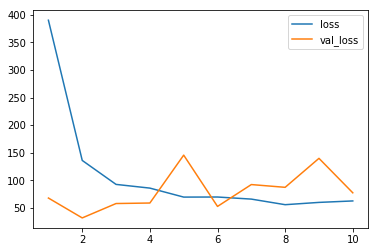

In [48]:
plt.plot(x_epochs,np.asarray(history.history['loss']),label='loss')
plt.plot(x_epochs,np.asarray(history.history['val_loss']),label='val_loss')
plt.legend(loc='best')
plt.show()

(158, 238, 1)
3


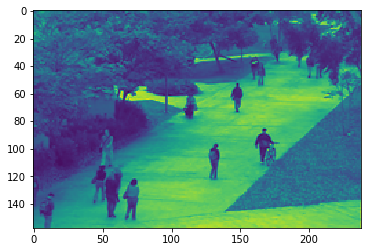

In [84]:
"""
#using tf dataset
filenames = tf.constant(lab_files)
labels = tf.constant(counts)

dataset = tf.data.Dataset.from_tensor_slices((filenames,labels))

def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=1)#grayscale imgs
    image_decoded.set_shape((158,238,1))
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)
#dataset = dataset.batch(2) #????

iterator = dataset.make_one_shot_iterator()
images, labels = iterator.get_next()
DS_size=400
train_data = dataset.take(int(0.75*DS_size))
test_data = dataset.skip(int(0.75*DS_size))
"""

file = '../ucsdpeds_vidf/video/vidf/vidf1_33_000.y/vidf1_33_000_f064.png'
filename_queue = tf.train.string_input_producer([file]) #  list of files to read

reader = tf.WholeFileReader()
key, value = reader.read(filename_queue)

my_img = tf.image.decode_png(value) # use png or jpg decoder based on your files.

init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)

    # Start populating the filename queue.

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for i in range(1): #length of your filename list
        image = my_img.eval() #here is your image Tensor :) 

    print(image.shape)
    print(image.ndim)
    plt.imshow(np.asarray(image)[:,:,0])
    plt.show()
    

    coord.request_stop()
    coord.join(threads)